In [ ]:
#Handy code to check Google Colab GPU status
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 31 12:52:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Handy code to check specs of current Google Colab Virtual Instance
!lscpu |grep 'Model name'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!free -h --si | awk  '/Mem:/{print $2}'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Core(s) per socket:  2
Thread(s) per core:  2
26G


In [ ]:
#Connect to Google Drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWi5PF5mian16Lkc7u3RMpMdxfRBYkfNKNLpLmDKjO9v_wFeMV_MHTE


In [ ]:
#Import the dataset constructed in dataset.ipynb
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/small.csv",index_col=0)

In [ ]:
#Again, define the fixed length of text segments
SEQ_LEN=1024

In [ ]:
#Install Hugging Face's transformers package
pip install transformers

     |████████████████████████████████| 3.1 MB 8.3 MB/s 
     |████████████████████████████████| 3.3 MB 66.2 MB/s 
     |████████████████████████████████| 895 kB 89.0 MB/s 
     |████████████████████████████████| 596 kB 80.3 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Import model tokenizer and tokenize the dataset
from transformers import AutoTokenizer, GPT2Tokenizer,BertTokenizerFast,LongformerTokenizerFast,RobertaTokenizerFast
import numpy as np

tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')
tokenizer.eos_token = "[PAD]"
tokenizer.pad_token = tokenizer.eos_token

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

#Initialize two arrays for input tensors
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

for i, sentence in enumerate(df['Text']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i, "samples completed") 

0
10000
20000
30000
40000
50000
60000


In [ ]:
import tensorflow as tf
import numpy as np

BATCH_SIZE = 4  

#Load arrays from the tokenizer into a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, np.array(df["Label"])))

#Restructure dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

#Shuffle data and batch it
dataset = dataset.shuffle(100000).batch(BATCH_SIZE)

In [ ]:
#Delete dataframe dataset to save space (as we have constructed a tensorflow dataset for model use)
del df

In [ ]:
#Get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.8  # 80-20 split

train = dataset.take(round(DS_LEN*SPLIT))  #Get first 80% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  #Skip first 80% and keep final 20%

del dataset  #Delete full dataset to save space (as we have split the full dataset into train and val subsets)

In [ ]:
#Load pre-trained transformer 
modelname = "bert-large-uncased"

from transformers import TFBertModel, BertConfig,LongformerConfig,TFLongformerModel,TFAutoModel,TFRobertaModel,RobertaConfig,GPT2Config, AutoConfig

#Initialize a model configuration
configuration = AutoConfig.from_pretrained(modelname,n_positions=SEQ_LEN,num_labels=2)

#Initialize a model from the configuration
transformer = TFAutoModel.from_config(config=configuration)

#Access the model configuration
configuration = transformer.config


'\nconfiguration = bert.config\n'

In [ ]:
#Define the model architecture
import tensorflow as tf
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

#Consume the last_hidden_state tensor from the transformer
embeddings = transformer(input_ids, attention_mask=mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(4, activation='relu')(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(X)

#Define input and output layers of the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

#Freeze the transformer layer
model.layers[2].trainable = False

In [ ]:
#Show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 1024)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 1024)]       0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 1024                                           

In [ ]:
#Use mixed float 16 to save training time
policy=tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
#Compile and train the model
optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.BinaryCrossentropy()  
acc = tf.keras.metrics.BinaryAccuracy('accuracy')
auc=tf.keras.metrics.AUC()

model.compile(optimizer=optimizer, loss=loss, metrics=[acc,auc])

history = model.fit(train, validation_data=val,steps_per_epoch=120,validation_steps=30, epochs=20, batch_size=32)

Epoch 1/20
120/120 [==============================] - 466s 4s/step - loss: 0.6701 - accuracy: 0.6286 - auc: 0.5364 - val_loss: 0.6791 - val_accuracy: 0.6292 - val_auc: 0.5632
Epoch 2/20
120/120 [==============================] - 437s 4s/step - loss: 0.6547 - accuracy: 0.6578 - auc: 0.5554 - val_loss: 0.6636 - val_accuracy: 0.6542 - val_auc: 0.6126
Epoch 3/20
120/120 [==============================] - 437s 4s/step - loss: 0.6547 - accuracy: 0.6292 - auc: 0.5827 - val_loss: 0.8255 - val_accuracy: 0.6479 - val_auc: 0.6776
Epoch 4/20
120/120 [==============================] - 437s 4s/step - loss: 0.6316 - accuracy: 0.6490 - auc: 0.6073 - val_loss: 2.1447 - val_accuracy: 0.6208 - val_auc: 0.5776
Epoch 5/20
120/120 [==============================] - 437s 4s/step - loss: 0.6379 - accuracy: 0.6432 - auc: 0.6016 - val_loss: 1.8230 - val_accuracy: 0.6438 - val_auc: 0.6252
Epoch 6/20
120/120 [==============================] - 437s 4s/step - loss: 0.6458 - accuracy: 0.6245 - auc: 0.6085 - val_loss

In [ ]:
#Save training history into .csv
hist_df=pd.DataFrame(history.history)
hist_csv_file = 'shortBERTAdam.001.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

NameError: ignored

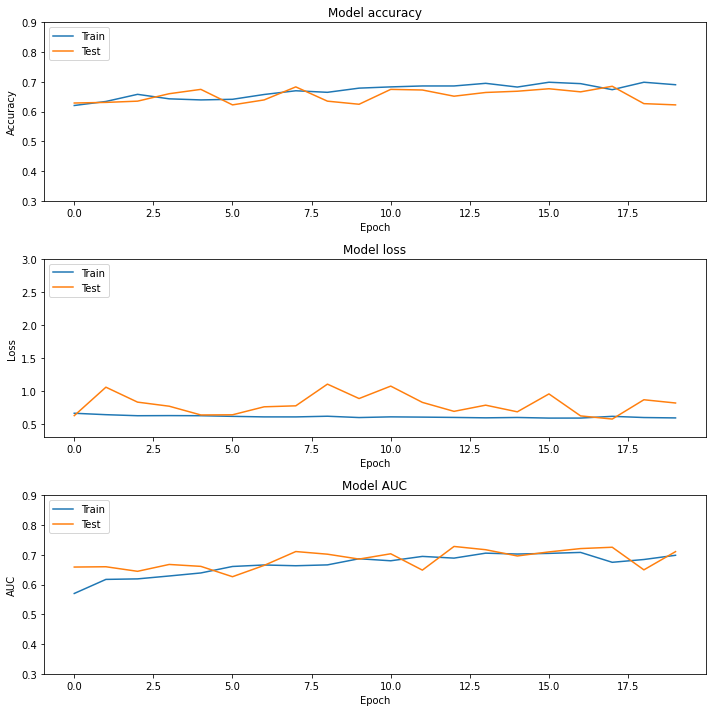

In [ ]:
#Optional: Plot training process with Matplotlib
import matplotlib.pyplot as plt

plt.subplot(3,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3,0.9)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(3,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(0.3,3)

plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(3,1,3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.ylim(0.3,0.9)

plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')


plt.tight_layout()

plt.savefig('plots.png',dpi=300)